In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from collections import Counter
from seaborn import heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from spacy.tokens import Doc, Token, Span

import gensim
import nltk

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel

In [11]:
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy

## TF_IDF Recommenders 

Cosine Similarity dictionary code for TF-IDF recommendations based on JeelSukhadiya (https://github.com/JeelSukhadiya/Recommendation-system/blob/master/Untitled23.ipynb)

### Cosine Similarity, Lemmatized & Stopwords Removed

In [3]:
df=pd.read_csv('../tfidf_data.csv')

In [4]:
df['global_id']=df['Unnamed: 0']

In [5]:
df.head()

Unnamed: 0                          story_title                                         story_text  book_id                     book_author                                         book_title  word_count                                               docs                                              nouns                                              verbs  global_id
0        9802             Whittier, John Greenleaf  Biography: VII, 381.   Selections: Barbara Fri...    24857      Sylvester, Charles Herbert      Journeys Through Bookland, Vol. 10: The Guide          76  Biography VII 381    Selections Barbara Frietc...                                                 []                                                 []       9802
1       12829                     The Stone Blocks  "Why is your little sister crying, dear?" aske...    19892  Richards, Laura Elizabeth Howe           The Silver Crown: Another Book of Fables         206  little sister cry dear ask Play Angel think ta...  [sister, care, care, child, care, care, Angel,...  [cry, ask, Play, think, take, take, say, cry, ...      12829
2       16036  After A Fairy Tale By Hans Andersen  THERE was no more beautiful thing in the world...    45907                   Dulac, Edmund  Edmund Dulac's Picture-Book for the French Red...        4147  beautiful thing world palace emperor China bui...  [thing, world, palace, emperor, porcelain, egg...  [build, move, break, fear, garden, contain, at...      16036
3       12623         The Ants And The Grasshopper  One bright day in late autumn a family of Ants...    19994                           Aesop  The Aesop for Children\r\nWith pictures by Mil...         139  bright day late autumn family Ants bustle warm...  [day, autumn, family, Ants, sunshine, grain, s...  [starve, come, beg, bite, eat, cry, surprise, ...      12623
4       12552        The Butcher And His Customers  Two Men were buying meat at a Butcher's stall ...    11339                           Aesop                  Aesop's Fables; a new translation         125  Men buy meat Butcher stall market place Butche...  [Men, meat, Butcher, stall, market, place, But...  [buy, snatch, thrust, see, turn, steal, say, s...      12552

In [6]:
df= df[['story_title', 'story_text', 'book_id', 'book_author', 'book_title', 'word_count', 'docs', 'global_id']]

In [7]:
df['tfidf_ready']=df.docs.apply(lambda x: x.lower())

In [8]:
tf=TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')

In [9]:
tfidf_matrix = tf.fit_transform(df['tfidf_ready'])

In [247]:
df.tfidf_ready.shape

(4293,)

In [281]:
tfidf_matrix.shape

(4293, 3431136)

### TF-IDF Cosine Similarity

In [18]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [19]:
results = {}

In [29]:
df[df.story_title=='The Sleeping Beauty'] 

story_title                                         story_text  book_id                                     book_author                                         book_title  word_count                                               docs  global_id                                        tfidf_ready
3006  The Sleeping Beauty  Once upon a time there lived a King and a Quee...    51275  ('Perrault, Charles', 'Quiller-Couch, Arthur')  The Sleeping Beauty and other fairy tales from...        4889  time live King Queen lack thing earth entirely...      14707  time live king queen lack thing earth entirely...
3979  The Sleeping Beauty   Once upon a time there lived a King and Queen...    20748                                     frozenset()                               Favorite Fairy Tales        1404    time live King Queen child long child little...      14892    time live king queen child long child little...
4170  The Sleeping Beauty  There were once a King and Queen who had no ch...    49001                                 Pyle, Katharine                             Mother's Nursery Tales        2053  King Queen child marry year little daughter be...      17898  king queen child marry year little daughter be...

This code builds a results dictionary for each sample

In [20]:

for index in df.index:
    similar_indices = cosine_similarities[index].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[index][i], df.index[i], df['story_title'][i]) for i in similar_indices]

    results[index] = similar_items[1:]

In [86]:
df.loc[2461, 'story_text']

'Once upon a time, when it was the story age, and things were very different from what they are now, two tribes of pygmies lived very near each other. These tribes of little people looked just alike, they both were very, very tiny, and they both lived out of doors in the fields. But in one respect they were quite different. One tribe of little folks spent a great deal of time gathering food of all kinds from the woods and the wild orchards, and storing it away for the winter. The other tribe of little people never harvested or saved at all; they spent all their time playing. "Come and have a good time with us; winter is a long way off, and you are wasting these sunny days," the lazy pygmies would call to the industrious ones. But the busy pygmies always made the same reply to their little neighbors, "It is you who are wasting these days. Winter may be far away, but it will be cold and barren when it does come. Everything will be covered deep with snow, and what will we eat if we do not

### Results for TF-IDF Cosine Similarity dictionary

4 out of the ten results are retellings/ other translations of the Aesop story or just feature a grasshopper. While these stories will be great down the road,  to my mind the only successful ones were those that worked with the themes of the original, the juxtaposition of productivity and laziness.

In [382]:
results[3][:27]

[(0.12781466011957418, 1466, 'The Grasshopper And The Ants'),
 (0.09398582299305516, 174, 'The Ants And The Grasshopper'),
 (0.07706662088383802, 1538, 'A Happy Day'),
 (0.0765917301013657, 2368, 'Jacksonville, Ill'),
 (0.051425549366150784, 771, 'The Ants And The Grasshopper'),
 (0.035719404969715284, 2706, 'The Two Grasshoppers'),
 (0.02908945903079182, 2461, 'Why The Bees Gather Honey'),
 (0.028014644249972916, 3927, 'The Last Party Of The Season'),
 (0.02777173688316896, 1081, 'The Acrobat'),
 (0.02628553316344321, 652, 'Insect Stories:--'),
 (0.023293443591331005, 1983, 'The Grasshopper And The Ant'),
 (0.021602662955865326,
  3092,
  'Adapted From The Autobiography Of Davy Crockett'),
 (0.021295689878436254, 798, 'The Summer Princess'),
 (0.021065176515298104, 2830, 'The Golden Branch'),
 (0.020678926867338562, 2664, 'Jesper Who Herded The Hares'),
 (0.01990033586010506, 3548, 'Wishes Exposed'),
 (0.019395764721704383, 1586, 'Little Cowboy'),
 (0.019011183480105345, 112, 'Haymaki

In [250]:
results[3][:27]

[(0.12781466011957418, 1466, 'The Grasshopper And The Ants'),
 (0.09398582299305516, 174, 'The Ants And The Grasshopper'),
 (0.07706662088383802, 1538, 'A Happy Day'),
 (0.0765917301013657, 2368, 'Jacksonville, Ill'),
 (0.051425549366150784, 771, 'The Ants And The Grasshopper'),
 (0.035719404969715284, 2706, 'The Two Grasshoppers'),
 (0.02908945903079182, 2461, 'Why The Bees Gather Honey'),
 (0.028014644249972916, 3927, 'The Last Party Of The Season'),
 (0.02777173688316896, 1081, 'The Acrobat'),
 (0.02628553316344321, 652, 'Insect Stories:--'),
 (0.023293443591331005, 1983, 'The Grasshopper And The Ant'),
 (0.021602662955865326,
  3092,
  'Adapted From The Autobiography Of Davy Crockett'),
 (0.021295689878436254, 798, 'The Summer Princess'),
 (0.021065176515298104, 2830, 'The Golden Branch'),
 (0.020678926867338562, 2664, 'Jesper Who Herded The Hares'),
 (0.01990033586010506, 3548, 'Wishes Exposed'),
 (0.019395764721704383, 1586, 'Little Cowboy'),
 (0.019011183480105345, 112, 'Haymaki

In [251]:
tfidf_results_dict=results

In [33]:
df.loc[2980, 'story_text']

'There were formerly a king and a queen, who were so sorry that they had no children; so sorry that it cannot be expressed. They went to all the waters in the world; vows, pilgrimages, all ways were tried, and all to no purpose. At last, however, the Queen had a daughter. There was a very fine christening; and the Princess had for her god-mothers all the fairies they could find in the whole kingdom (they found seven), that every one of them might give her a gift, as was the custom of fairies in those days. By this means the Princess had all the perfections imaginable. After the ceremonies of the christening were over, all the company returned to the King’s palace, where was prepared a great feast for the fairies. There was placed before every one of them a magnificent cover with a case of massive gold, wherein were a spoon, knife, and fork, all of pure gold set with diamonds and rubies. But as they were all sitting down at table they saw come into the hall a very old fairy, whom they h

#### Functions made to make results more human readable, later leveraged in designing WebApp

In [80]:
def give_story_data(book_id):
    story_dict={}
    story_dict['title']=df.loc[book_id, 'story_title']
    story_dict['book']=df.loc[book_id, 'book_title']
    story_dict['author']=df.loc[book_id, 'book_author']
    message=f"{story_dict['title']} \nFrom {story_dict['book']} \nBy {story_dict['author']}\n"
    return message

In [81]:
def present_n_options(book_id, n=9):
    all_results=results[book_id][:3*n]
    strong_options= [result[1] for result in all_results[:n]]
    medium_options=[result[1] for result in all_results[n:2*n]]
    weak_options=[result[1] for result in all_results[2*n:3*n]]
    
    row_1_ids= [strong_options[random.randint(0,n-1)], weak_options[random.randint(0,n-1)], medium_options[random.randint(0,n-1)]]
    
    row_2_ids= [strong_options[random.randint(0,n-1)], weak_options[random.randint(0,n-1)], medium_options[random.randint(0,n-1)]]
    
    row_3_ids=[strong_options[random.randint(0,n-1)], weak_options[random.randint(0,n-1)], medium_options[random.randint(0,n-1)]]
    
    rows=[row_1_ids, row_2_ids, row_3_ids]
    for row in rows:
        for id in row:
            print(give_story_data(id))
            print('\n')



In [89]:
present_n_options(3)

Jacksonville, Ill 
From The Grasshopper Stories 
By Leavitt, Elizabeth Davis



The Grateful Foxes 
From Nature Myths and Stories for Little Children 
By Cooke, Flora J. (Flora Juliette)



Insect Stories:-- 
From Nature Myths and Stories for Little Children 
By Cooke, Flora J. (Flora Juliette)



The Ants And The Grasshopper 
From Æsop's Fables 
By Aesop



The Marvellous Musician 
From The Red Fairy Book 
By frozenset()



Insect Stories:-- 
From Nature Myths and Stories for Little Children 
By Cooke, Flora J. (Flora Juliette)



Why The Bees Gather Honey 
From Tell Me Another Story: The Book of Story Programs 
By Bailey, Carolyn Sherwin



The Palace Of Alkinoös 
From Nature Myths and Stories for Little Children 
By Cooke, Flora J. (Flora Juliette)



Haymaking 
From Our Young Folks at Home and Abroad 
By frozenset()





In [252]:
give_story_data(3)

'The Ants And The Grasshopper \nFrom The Aesop for Children\r\nWith pictures by Milo Winter \nBy Aesop\n'

In [96]:
#To my mind, one of the more successful recommendations from TF-IDF based model, 
#A story about a priest who gets help by playing the fiddle. It provides a good counterpoint to the Grasshopper story.
df.loc[3092, 'story_text']

'Little Rock lay on my way to Texas, and as I left it several companions accompanied me a short distance from the village. We were talking briskly together as we drew near the Washita River, and imagined ourselves the only travelers in that vicinity. In a lull in the conversation we were somewhat startled by the sound of music, evidently not far away. We checked our horses and listened, while the music continued. "What can all that mean?" asked I. "Blast my old shoes if I know," said one of the party. We listened again and heard Hail Columbia! Happy Land! played in first-rate style. "That\'s fine," said I. "Fine as silk, Colonel, and a leetle finer," said another; "but hark! the tune is changed." We listened again, and the musician struck up in a brisk and lively manner, Over the Water to Charlie. "That\'s mighty mysterious," said one of my friends. "Can\'t cipher it out nohow," said another. "A notch beyant my measure," said a third. "Then let\'s see what it is," said I, and off we da

### Word Cloud Visualizations for "The Ant and the Grasshopper Results" from TFIDF

To figure this out I followed this article, https://www.scss.tcd.ie/~munnellg/projects/visualizing-text.html

In [257]:
from collections import Counter

In [339]:
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS

In [276]:
tfidf_model_words=[word for result in tfidf_results_dict[3][:30] for word in df.loc[result[1],'tfidf_ready'].split(' ')]
    p

In [ ]:
for result in tfidf_results_dict[3][30]:

In [285]:
feature_names = tf.get_feature_names()


In [323]:
tfidf_scores=[]
for result in tfidf_results_dict[3][:30]:
    feature_index = tfidf_matrix[result[1],:].nonzero()[1]
    tfidf_scores+=[item for item in list(zip(feature_index, [tfidf_matrix[result[1], x] for x in feature_index]))]

In [325]:
len(tfidf_scores)

72045

In [331]:
d = defaultdict(float)
for x, y in tfidf_scores:
    d[x] += float(y)



In [290]:
type(zip(feature_index, [tfidf_matrix[result[1], x] for x in feature_index]))

zip

In [356]:
word_cloud_weights={w: s*100 for w, s in [(feature_names[i], s) for (i, s) in d.items()]}

In [357]:
word_cloud_weights

{'dance chuckle work': 9.862597301266348,
 'winter dance chuckle': 9.862597301266348,
 'spend winter dance': 9.862597301266348,
 'ants spend winter': 9.862597301266348,
 'reply ants spend': 9.862597301266348,
 'singe reply ants': 9.862597301266348,
 'summer singe reply': 9.862597301266348,
 'spend summer singe': 9.862597301266348,
 'time spend summer': 9.862597301266348,
 'singe time spend': 9.862597301266348,
 'busy singe time': 9.862597301266348,
 'grasshopper busy singe': 9.862597301266348,
 'reply grasshopper busy': 9.862597301266348,
 'fact reply grasshopper': 9.862597301266348,
 'winter fact reply': 9.862597301266348,
 'food winter fact': 9.862597301266348,
 'collect store food': 9.862597301266348,
 'summer collect store': 9.862597301266348,
 'say summer collect': 9.862597301266348,
 'ask say summer': 9.862597301266348,
 'principle ask say': 9.862597301266348,
 'moment principle ask': 9.862597301266348,
 'work moment principle': 9.862597301266348,
 'stop work moment': 9.401455816

In [343]:
tfidf_wordcloud_adjusted= ' '.join([word*int(value*100) for word, value in word_cloud_weights])

In [345]:
tfidf_wordcloud_adjusted[:100]

'dance chuckle workdance chuckle workdance chuckle workdance chuckle workdance chuckle workdance chuc'

In [359]:
wc = WordCloud(
    background_color="white",
    max_words=2000,
    width = 1024,
    height = 720,
    stopwords=STOPWORDS
)
wc.generate_from_frequencies(word_cloud_weights)
wc.to_file("tfidf_word_cloud.png")

## Spacy Doc Similarity Recommendation

In [90]:

nlp = spacy.load('en_core_web_md')

In [91]:
def check_stop_punct(token):
    if token.is_stop or token.is_punct:
        return False
    else:
        return True

def clean_doc_lem_stop(document):
    no_stop_li = list(filter(check_stop_punct, document))
    lemma_li = list(map(lambda x: x.lemma_, no_stop_li))
    spaces=[True for word in lemma_li]
    doc=Doc(nlp.vocab, words=lemma_li, spaces=spaces)
    return doc

In [92]:
nlp.add_pipe(clean_doc_lem_stop, first=True)
nlp.pipe_names

['clean_doc_lem_stop', 'tagger', 'parser', 'ner']

In [94]:
df.docs= list(nlp.pipe(df.story_text))

In [176]:
grasshopper=[]
for index in df.index:
    grasshopper.append(df.loc[3, 'docs'].similarity(df.loc[index,'docs']))


In [361]:
grasshopper_indices = [grasshopper.index(value) for value in sorted(grasshopper, reverse=True)]
similar_items = [(grasshopper[i], df.index[i], df['story_title'][i]) for i in grasshopper_indices]
similar_items[1:101]

[(0.9651225787144277, 1466, 'The Grasshopper And The Ants'),
 (0.9618173570496843, 3927, 'The Last Party Of The Season'),
 (0.9539781786986786, 262, 'The Selfish Tent-Caterpillar'),
 (0.9529063572570352, 1929, 'The Thrifty Deer Mouse'),
 (0.9523853026528956, 555, "If; Or, Bessie Green'S Holiday"),
 (0.9520565303833178, 2461, 'Why The Bees Gather Honey'),
 (0.9496879441667868, 3826, "The Tree Frog'S Story"),
 (0.9496804873977626, 2142, 'The Dandelion Children'),
 (0.9477617691128888, 3762, 'An Australian Story'),
 (0.9472166281991122, 1547, 'The Brownies’ Plum Pudding'),
 (0.9467618204358159, 1366, 'An Idyll Of The Wood'),
 (0.9465196542761571, 1496, 'A Summer At Willow-Spring'),
 (0.9465014718174667,
  1211,
  'About Trowel Ku The Beaver Who Builds Dams. About Kanecri The Loon Who Sings On The Lakes. About Hoota The Owl Who Is Not So Wise As He Looks. About Weeska The Fox Who Is Just As Sharp As His Own Nose, And That Is Saying A Great Deal'),
 (0.9464541497752176, 346, 'The Discontent

(array([   6.,    7.,    4.,   12.,   18.,   52.,   91.,  346., 2022.,
        1735.]),
 array([0.05663815, 0.15097434, 0.24531052, 0.33964671, 0.43398289,
        0.52831908, 0.62265526, 0.71699145, 0.81132763, 0.90566382,
        1.        ]),
 <a list of 10 Patch objects>)

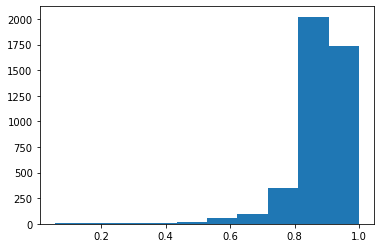

In [190]:
plt.hist([item[0] for item in similar_items])

#### Here I started testing a query function that I would implement on the front end

In [227]:
test_doc=nlp('Genie grants three wishes')
test_case=[]
for index in df.index:
    test_case.append(test_doc.similarity(df.loc[index,'docs']))

In [228]:
test_case_indices = [test_case.index(value) for value in sorted(test_case, reverse=True)]
similar_genie_sentence_items = [(test_case[i], df.index[i], df['story_title'][i]) for i in test_case_indices]
similar_genie_sentence_items[1:101]

[(0.7457176988444901, 3081, 'My Dear Pasha,'),
 (0.7373759507421426, 620, 'The Messengers Of The Fairy Queen'),
 (0.7371032419006733, 1718, 'As Told By Mary Seymour'),
 (0.735992942088741, 3608, 'Marriage Lottery'),
 (0.735152359763489, 3002, '“Mary Durell.”'),
 (0.7337514446589937, 671, 'Projects'),
 (0.7326692560303928,
  2178,
  'The History Of The Second Old Man And The Two Black Dogs'),
 (0.7324280192866819, 4044, 'To My Sabbath-School Class'),
 (0.7309254842924879, 1784, 'The Reward'),
 (0.730784673683131, 3596, 'Edmund.”'),
 (0.7303324423805317, 4289, 'Aladdin And The Wonderful Lamp'),
 (0.7299279223729809, 2080, 'Forty-Seventh Night'),
 (0.7298500152971436, 2480, 'Adapted From The Brothers Grimm'),
 (0.7291411108848455, 2122, 'Lotteries'),
 (0.7290222454905297, 830, "Daffey'S Elixir"),
 (0.7290109062482034, 4032, 'The Happy Ending Of The Story'),
 (0.7285304477952528,
  3331,
  'In Which Bobby Opens Various Accounts, And Wins His First Victory'),
 (0.7280345557828198, 1271, 'Th

In [241]:
test_doc=nlp('A hacker tries to break out of the simulation in bullet-time.')
test_case=[]
for index in df.index:
    test_case.append(test_doc.similarity(df.loc[index,'docs']))
test_case_indices = [test_case.index(value) for value in sorted(test_case, reverse=True)]
similar_genie_items = [(test_case[i], df.index[i], df['story_title'][i]) for i in test_case_indices]
similar_genie_items[1:50]

[(0.7859118390787384, 3898, 'The Cat And The Fox'),
 (0.7847360064515747, 3763, 'The Hare And The Tortoise'),
 (0.7845134207653838, 2688, 'Fishing For A Prize'),
 (0.7839820581332122, 758, 'White Wings And Red'),
 (0.7815993874408662, 1717, 'Don Tests A Theory'),
 (0.7807682079263875, 643, '"The Man Who Never Lived"'),
 (0.7801747901315293, 3072, 'Fishing For A Friend'),
 (0.7786068702384719, 2096, 'Free Of Charge'),
 (0.7785458638749404, 2851, 'Anonymous'),
 (0.7781472533716822, 1651, 'The Mouse And The Weasel'),
 (0.7778438432211872, 3868, 'A Clue In Smoke'),
 (0.7763341134921887, 3426, 'A Fortunate Diversion'),
 (0.7761606478886641, 477, 'Sunlight And Hope'),
 (0.7754727546442123, 2511, 'A Question Of Angles'),
 (0.7741984011016179, 1917, 'In Self-Defense'),
 (0.7740736932955271, 2893, 'The Retreat--At Bay'),
 (0.7739005308448925, 708, 'Bluffing Up To The Big Game'),
 (0.7734432907938859, 387, 'Alone In The Gloom'),
 (0.7733075652586814, 4173, 'Under The Bank'),
 (0.7731121717494402

In [187]:
df.loc[1322, 'story_text']

'Some of the old builders,--not the very old ones, for they built nothing but rope-walks down behind the hill,--but some of those who began to go northwest from the State House to live, made a pleasant group of streets down there on the level stretching away to the river, and called them by fresh, fragrant, country-suggesting names. Names of trees and fields and gardens, fruits and blossoms; and they built houses with gardens around them. In between the blocks were deep, shady places; and the smell of flowers was tossed back and forth by summer winds between the walls. Some nice old people stayed on there, and a few of their descendants stay on there still, though they are built in closely now, for the most part, and coarse, common things have much intruded, and Summit Street overshadows them with its palaces. Here and there a wooden house, set back a little, like this of the Ripwinkleys in Aspen Street, gives you a feeling of Boston in the far back times, as you go by; and here and th

In [172]:
grasshopper[:10]

[0.5851873761522888,
 0.8905121145753876,
 0.932444600801198,
 1.0,
 0.8532125136610704,
 0.8750038572494694,
 0.876138877714867,
 0.911838310834249,
 0.8971019207863065,
 0.8801935704287349]

In [158]:
df.loc[4, 'story_text']

'Two Men were buying meat at a Butcher\'s stall in the market-place, and, while the Butcher\'s back was turned for a moment, one of them snatched up a joint and hastily thrust it under the other\'s cloak, where it could not be seen. When the Butcher turned round, he missed the meat at once, and charged them with having stolen it: but the one who had taken it said he hadn\'t got it, and the one who had got it said he hadn\'t taken it. The Butcher felt sure they were deceiving him, but he only said, "You may cheat me with your lying, but you can\'t cheat the gods, and they won\'t let you off so lightly."   Prevarication often amounts to perjury.'

In [160]:
results[3][:27]

[(0.12781466011957418, 1466, 'The Grasshopper And The Ants'),
 (0.09398582299305516, 174, 'The Ants And The Grasshopper'),
 (0.07706662088383802, 1538, 'A Happy Day'),
 (0.0765917301013657, 2368, 'Jacksonville, Ill'),
 (0.051425549366150784, 771, 'The Ants And The Grasshopper'),
 (0.035719404969715284, 2706, 'The Two Grasshoppers'),
 (0.02908945903079182, 2461, 'Why The Bees Gather Honey'),
 (0.028014644249972916, 3927, 'The Last Party Of The Season'),
 (0.02777173688316896, 1081, 'The Acrobat'),
 (0.02628553316344321, 652, 'Insect Stories:--'),
 (0.023293443591331005, 1983, 'The Grasshopper And The Ant'),
 (0.021602662955865326,
  3092,
  'Adapted From The Autobiography Of Davy Crockett'),
 (0.021295689878436254, 798, 'The Summer Princess'),
 (0.021065176515298104, 2830, 'The Golden Branch'),
 (0.020678926867338562, 2664, 'Jesper Who Herded The Hares'),
 (0.01990033586010506, 3548, 'Wishes Exposed'),
 (0.019395764721704383, 1586, 'Little Cowboy'),
 (0.019011183480105345, 112, 'Haymaki

In [97]:
df['doc_vector']=df.docs.apply(lambda x: x.vector)

In [103]:
doc_vectors=df.docs.apply(lambda x: x.vector)

In [244]:
linear_kernel()

array([[ 2.9769628e-03,  5.6343190e-03, -1.0162830e-02, ...,
        -4.4304109e-04, -3.7098646e-03, -1.6092451e-03],
       [ 4.3566143e-03,  8.2455026e-03, -1.4872719e-02, ...,
        -6.4836524e-04, -5.4291738e-03, -2.3550380e-03],
       [-3.5229591e-03, -6.6676936e-03,  1.2026765e-02, ...,
         5.2429800e-04,  4.3902802e-03,  1.9043921e-03],
       ...,
       [ 9.0980646e-04,  1.7219360e-03, -3.1059198e-03, ...,
        -1.3540029e-04, -1.1337927e-03, -4.9181050e-04],
       [-3.8887674e-04, -7.3600368e-04,  1.3275571e-03, ...,
         5.7873873e-05,  4.8461472e-04,  2.1021356e-04],
       [ 3.2864390e-03,  6.2200455e-03, -1.1219326e-02, ...,
        -4.8909825e-04, -4.0955306e-03, -1.7765373e-03]], dtype=float32)

In [106]:
pd.DataFrame(doc_vectors)

docs
0     [0.0753867, 0.12672444, 0.12702775, -0.1652316...
1     [-0.09398392, 0.12934205, -0.21213582, -0.0440...
2     [-0.014414963, 0.09698749, -0.1008541, -0.0694...
3     [0.06921052, 0.10128563, -0.081904225, -0.1034...
4     [-0.18905869, 0.031168668, -0.025609955, 0.074...
...                                                 ...
4288  [-0.06448851, 0.03834724, -0.15708102, -0.0250...
4289  [0.000902765, 0.058553316, -0.08697756, -0.044...
4290  [-0.08020907, 0.0741131, 0.006689033, -0.07121...
4291  [-0.0031149667, 0.11928318, -0.1596479, 0.0498...
4292  [-0.07189585, 0.098061495, -0.15953371, 0.0561...

[4293 rows x 1 columns]

## Data Visualizations for spaCy Model

In [377]:
similar_items

[(1.0, 3, 'The Ants And The Grasshopper'),
 (0.9651225787144277, 1466, 'The Grasshopper And The Ants'),
 (0.9618173570496843, 3927, 'The Last Party Of The Season'),
 (0.9539781786986786, 262, 'The Selfish Tent-Caterpillar'),
 (0.9529063572570352, 1929, 'The Thrifty Deer Mouse'),
 (0.9523853026528956, 555, "If; Or, Bessie Green'S Holiday"),
 (0.9520565303833178, 2461, 'Why The Bees Gather Honey'),
 (0.9496879441667868, 3826, "The Tree Frog'S Story"),
 (0.9496804873977626, 2142, 'The Dandelion Children'),
 (0.9477617691128888, 3762, 'An Australian Story'),
 (0.9472166281991122, 1547, 'The Brownies’ Plum Pudding'),
 (0.9467618204358159, 1366, 'An Idyll Of The Wood'),
 (0.9465196542761571, 1496, 'A Summer At Willow-Spring'),
 (0.9465014718174667,
  1211,
  'About Trowel Ku The Beaver Who Builds Dams. About Kanecri The Loon Who Sings On The Lakes. About Hoota The Owl Who Is Not So Wise As He Looks. About Weeska The Fox Who Is Just As Sharp As His Own Nose, And That Is Saying A Great Deal'),

In [378]:
indices= [result[1] for result in similar_items[1:100]]

In [379]:
spacy_word_cloud_string=' '.join([doc for index in indices for doc in df.loc[index,'tfidf_ready'].split(' ')])

In [380]:
spacy_word_cloud_string

'fine day winter ants busy dry store corn get damp long spell rain presently come grasshopper beg spare grain say simply starve ants stop work moment principle ask say summer collect store food winter fact reply grasshopper busy singe time spend summer singe reply ants well spend winter dance chuckle go work  summer joyful time meadow busy time morning till night chirp hum happy people mingle rustle leave soft swish swish tall grass wind pass true quarrel unpleasant thing remember little people wise throw away sad memory glad one summer leave forest tree turn green scarlet orange brown beech hickory nut wait friendly frost open outer shell loosen stem fall earth wind cold meadow people know time come ready winter chilly caterpillar say boo oo cold find place cocoon suppose sleep winter swinge bush friend reply hurry shall old stiff spin good one garter snake feel sleepy time declare day doze spring tree frog choose winter home bees make time visit fall flower gather bite honey find col

In [381]:
wc = WordCloud(
    background_color="white",
    max_words=2000,
    width = 1024,
    height = 720,
    stopwords=STOPWORDS
).generate(spacy_word_cloud_string)

wc.to_file("spacy_word_cloud.png")

## GenSim Doc Similarity

To compare the performance of the spaCy model and to assess next steps on training a model on the data set, a blank Doc2Vec model was created,

In [113]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [116]:
tagged_documents = []
for i, doc in enumerate(df.tfidf_ready):
    tagged = TaggedDocument(doc, [i])
    tagged_documents.append(tagged)

tagged_documents

[TaggedDocument(words='biography vii 381    selections barbara frietchie iii 347     barefoot boy iv 3   whittington cat 442   duty children 301   stole bird nest ii 399   sea salt ii 484   widow machree vi 464   wind 440   wind sun 95   windy nights ii 123   winter animals vii 293 ', tags=[0]),
 TaggedDocument(words='little sister cry dear ask play angel think take care take beautiful care say child beautiful care cry like care take let say play angel sit nursery floor look say child show doll new dress give new stone block play play put mouth cry hungry say play angel take piece bread fold robe give baby baby stop cry eat bread laugh crow say angel happy remember dear baby hungry stone block good clever angel know say child foolish child say angel find ', tags=[1]),
 TaggedDocument(words="beautiful thing world palace emperor china build fine porcelain delicate fragile egg shell people high low dwell palace move utmost grace care lest break admiration extreme beauty place fear trample

In [117]:
model = Doc2Vec(tagged_documents, vector_size=300, window=2, min_count=1, workers=4)

In [150]:
new_sentence = "grasshopper sings".split(" ")
new_sentence_vectorized = model.infer_vector(new_sentence)

# Calculate cosine similarity. 
vec_results=model.docvecs.most_similar(positive=[new_sentence_vectorized])

In [153]:
model

In [151]:
ids= [result[0] for result in vec_results]

In [152]:
for id in ids:
    print(give_story_data(id))
    print('\n')


The Grass Party 
From The Story of a White Rocking Horse 
By Hope, Laura Lee



Piccola 
From The Story Hour: A Book for the Home and the Kindergarten 
By ('Smith, Nora Archibald', 'Wiggin, Kate Douglas Smith')



Selected For Its Apperceptive Appeal 
From For the Story Teller: Story Telling and Stories to Tell 
By Bailey, Carolyn Sherwin



Aqva. De. Fonte. Leonvm. {130} 
From Prince Prigio 
By Lang, Andrew



Boots And His Brothers 
From Popular Tales from the Norse 
By frozenset()



When Proserpine Was Lost 
From Wonder Stories: The Best Myths for Boys and Girls 
By Bailey, Carolyn Sherwin



Aladdin And The Wonderful Lamp 
From The Blue Fairy Book 
By Lang, Andrew



The Story Of The Old Man Who Made Withered Trees To Flower 
From Japanese Fairy Tales 
By Ozaki, Yei Theodora



Jaky Tolbert’S Playmates 
From Floyd's Flowers; Or, Duty and Beauty for Colored Children
Being One Hundred Short Stories Gleaned from the Storehouse of Human Knowledge and Experience: Simple, Amusing, Eleva